重写了一遍，训练120轮次，识别效果稍微良好

自定义Model，自定义fit过程

特别注意：对spectrum进行卷积、降维时，Conv激活一定要有‘relu’

In [1]:
import os
import random
from glob import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
gpus = tf.config.list_physical_devices( 'GPU' )
tf.config.experimental.set_memory_growth( gpus[0], True )

首先处理文件

In [3]:
saveto = "data/LJSpeech-1.1"
wavs = glob("{}/**/*.wav".format(saveto), recursive=True)

id_to_text = {}
with open(os.path.join(saveto, "metadata.csv"), encoding="utf-8") as f:
    for line in f:
        id = line.strip().split("|")[0]
        text = line.strip().split("|")[2]
        id_to_text[id] = text


def get_data(wavs, id_to_text, maxlen=200):
    data = []
    for w in wavs:
        id = w.split("\\")[-1].split(".")[0]
        if len(id_to_text[id]) < maxlen:
            data.append({"audio": w, "text": id_to_text[id]})
    return data
data =  get_data(wavs, id_to_text)

In [4]:
char_set = ["-", "#", "<", ">"] + [chr(i + 96) for i in range(1, 27)] + [" ", ".", ",", "?"]
ids_dict = {}
for ids,letter in enumerate(char_set):
        ids_dict[letter]=ids

In [5]:
def VectorizeChar( text, maxlen=200 ):
    text = text.lower()
    text_chars = [_ for _ in text][:maxlen-2]
    text_vector = [2] + [ids_dict.get(_,1) for _ in text_chars] + [3]
    pad_len = maxlen - len(text_vector)
    text_vector = text_vector + [0]*pad_len
    return text_vector

In [6]:
def decode_spectrogram(path,sample_fre=22050):
    audio = tf.io.read_file(path)
    wav,_ = tf.audio.decode_wav(audio,1)
    wav = tf.squeeze(wav,-1)
    spectrum = tf.signal.stft(wav, frame_length=200, frame_step=80, fft_length=256)
    # 注意：这里相当于层正则化，LayerNormalization，即同一样本不同维度间的差异性更重要
    x = tf.math.pow(tf.abs(spectrum), 0.5)
    means = tf.math.reduce_mean(x,1,keepdims=True)
    stds = tf.math.reduce_std(x,1,keepdims=True)
    norm_spectrum = (x-means)/stds
    # 填充至10秒
    temporal_len = sample_fre*10; pad_len = (temporal_len-120)//80+1
    paddings = tf.constant([[0,pad_len],[0,0]])
    pad_spectrum = tf.pad(norm_spectrum, paddings, mode='CONSTANT')[:pad_len,:]
    return pad_spectrum

In [7]:
def create_ds(data,batch):
    text_in_vectors = [VectorizeChar(element['text'])[:-1] for element in data]
    text_out_vectors = [VectorizeChar(element['text'])[1:] for element in data]
    audio_paths = [element['audio'] for element in data]
    spectrum_ds = tf.data.Dataset.from_tensor_slices(audio_paths).map(decode_spectrogram)
    text_in_ds = tf.data.Dataset.from_tensor_slices(text_in_vectors)
    text_out_ds = tf.data.Dataset.from_tensor_slices(text_out_vectors)
    input_ds = tf.data.Dataset.zip((spectrum_ds, text_in_ds))
    ds = tf.data.Dataset.zip((input_ds, text_out_ds)).batch(batch).prefetch(tf.data.AUTOTUNE)
    return input_ds, text_out_ds, ds

train_data = data[:int(len(data)*0.9)]
val_data = data[int(len(data)*0.9):]

train_x, train_y, train_ds = create_ds(train_data,64)
val_x, val_y, val_ds = create_ds(val_data,4)

至此，以上生成Dataset

接下来，对text和频谱进行编码

In [8]:
class spectrum_embed(keras.layers.Layer):
    def __init__(self, filters=64):
        super().__init__()
        # 根据示例代码，对频谱进行卷积降维
        self.conv1 = keras.layers.Conv1D(filters,kernel_size=11,strides=2,padding='same',
                                         activation='relu', data_format='channels_last')
        self.conv2 = keras.layers.Conv1D(filters,kernel_size=11,strides=2,padding='same',
                                         activation='relu', data_format='channels_last')
        self.conv3 = keras.layers.Conv1D(filters,kernel_size=11,strides=2,padding='same',
                                         activation='relu', data_format='channels_last')
        
    def call(self,spectrum):
        x = self.conv1(spectrum)
        x = self.conv2(x)
        x = self.conv3(x)
        return x        

In [9]:
class text_embed(keras.layers.Layer):
    def __init__(self,embed_dim=64,maxlen=199):
        super().__init__()
        self.char_embed = keras.layers.Embedding(input_dim=34, output_dim=embed_dim)
        self.position_embed = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
        
    def call(self, text):
        char_embeddings = self.char_embed(text)
        seq_len = tf.shape(text)[-1]
        positions = tf.range(seq_len)
        position_embeddings = self.position_embed(text)
        embeddings = char_embeddings + position_embeddings
        return embeddings        

In [10]:
class encoder(keras.layers.Layer):
    def __init__(self,heads,embed_dim,ffn_dim,drop_rate):
        super().__init__()
        self.att = keras.layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([keras.layers.Dense(ffn_dim,activation='relu'),
                                    keras.layers.Dense(embed_dim)])
        self.drop1 = keras.layers.Dropout(rate=drop_rate)
        self.drop2 = keras.layers.Dropout(rate=drop_rate)
        self.ln1 = keras.layers.LayerNormalization(axis=-1,epsilon=1e-6)
        self.ln2 = keras.layers.LayerNormalization(axis=-1,epsilon=1e-6)
        
    def call(self, enc_input):
        att_out = self.att(query=enc_input, value=enc_input, attention_mask=None)
        ln1_out = self.ln1(enc_input+self.drop1(att_out, training=True))
        ffn_out = self.ffn(ln1_out)
        ln2_out = self.ln2(ln1_out+self.drop2(ffn_out, training=True))
        return ln2_out        

In [11]:
class decoder(keras.layers.Layer):
    def __init__(self,heads,embed_dim,ffn_dim,drop_rate):
        super().__init__()
        self.att1 = keras.layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.att2 = keras.layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([keras.layers.Dense(ffn_dim, activation='relu'),
                                    keras.layers.Dense(embed_dim)])
        self.drop1 = keras.layers.Dropout(rate=drop_rate)
        self.drop2 = keras.layers.Dropout(rate=drop_rate)
        self.drop3 = keras.layers.Dropout(rate=drop_rate)
        
        self.ln1 = keras.layers.LayerNormalization(axis=-1,epsilon=1e-6)
        self.ln2 = keras.layers.LayerNormalization(axis=-1,epsilon=1e-6)
        self.ln3 = keras.layers.LayerNormalization(axis=-1,epsilon=1e-6)
        
    def call(self,enc_out,dec_input):
        mask = self.create_mask(dec_input)
        att1_out = self.att1(dec_input,dec_input,attention_mask=mask)
        ln1_out = self.ln1(dec_input + self.drop1(att1_out, training=True))
        att2_out = self.att2(query=ln1_out,value=enc_out,attention_mask=None)
        ln2_out = self.ln2(ln1_out + self.drop2(att2_out, training=True))
        ffn_out = self.ffn(ln2_out)
        ln3_out = self.ln3(ln2_out + self.drop3(ffn_out, training=True))
        return ln3_out
    
    def create_mask(self,query):
        batch = tf.shape(query)[0]
        seq_len = tf.shape(query)[1]
        mat1 = tf.ones([seq_len, seq_len])
        mask = tf.linalg.band_part(mat1,-1,0)[tf.newaxis,:]
        
        tiles = tf.concat([batch[tf.newaxis], tf.constant([1,1])], axis=0)
        mask = tf.tile(mask,tiles)
        return mask

In [12]:
class Transformer(keras.Model):
    def __init__(self, enc_layers=4, dec_layers=2, heads=2, embed_dim=200, ffn_dim=400, maxlen= 199, drop_rate=0.1):
        super().__init__()
        self.wav_embed = spectrum_embed(embed_dim)
        self.txt_embed = text_embed(embed_dim,maxlen)
        
        self.encoders = [encoder(heads, embed_dim, ffn_dim, drop_rate) for _ in range(enc_layers)]
        self.decoders = [decoder(heads, embed_dim, ffn_dim, drop_rate) for _ in range(dec_layers)]
        
        self.classifier = keras.layers.Dense(34, activation='softmax')
        
        self.myloss = keras.metrics.Mean(name='ztl_loss')
        self.myAcc = keras.metrics.Mean(name='ztl_acc')
        
        self.seq_len = maxlen
        
    def call(self, inputs):
        enc_in = inputs[0]
        dec_in = inputs[1]
        x = self.wav_embed(enc_in)
        y = self.txt_embed(dec_in)
        
        for encoder in self.encoders:
            x = encoder(x)
        
        for decoder in self.decoders:
            y = decoder(x, y)
        
        output = self.classifier(y)
        return output
        
    @property
    def metrics(self):
        return [self.myloss, self.myAcc]
    
    def train_step(self, inputs):
        input_tuple = inputs[0]
        label = inputs[1]
        mask = tf.cast( tf.math.logical_not( tf.math.equal(label,0) ), tf.float32)
        with tf.GradientTape() as tape:
            pred = self(input_tuple)
            loss = self.compiled_loss(label, pred, sample_weight=mask) #
        trainable_weights = self.trainable_variables
        gradients = tape.gradient(loss, trainable_weights)
        self.optimizer.apply_gradients( zip(gradients, trainable_weights) )
        self.myloss.update_state(loss)
        
        pred_ = tf.math.argmax(pred, axis=-1, output_type=label.dtype)
        myacc = tf.cast( tf.math.equal(label, pred_), tf.float32)
        myacc_ = tf.reduce_sum(tf.multiply(myacc, mask))/tf.reduce_sum(mask)
        self.myAcc.update_state(myacc_)
        
        results ={};results['张泰龙_留白'] = 0.888
        results['张泰龙_cost'] = self.myloss.result()
        results['MyAcc'] = self.myAcc.result()
        
        return results
    
    def generate(self, spectrum):
        batch = tf.shape(spectrum)[0]
        dec_in = tf.ones([batch,1],dtype=tf.int32)*2
        for i in range(self.seq_len):
            pred = self([spectrum, dec_in])
            pred_ids = tf.math.argmax(pred, axis=-1, output_type=tf.int32)[:,-1:]
            dec_in = tf.concat([dec_in, pred_ids], axis=-1)
        tf.print(dec_in[:2,-8:])
        return dec_in

In [13]:
class MySchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self,init_lr=1e-5,peak_lr=1e-3,bottom_lr=1e-5,up_epochs=15,decay_epochs=85,epoch_steps=185):
        super().__init__()
        self.init = init_lr
        self.peak = peak_lr
        self.bottom = bottom_lr
        self.ascend = up_epochs
        self.descend = decay_epochs
        self.iter_steps = epoch_steps
        
    def calculate_lr(self,epoch):
        up_lr = self.init + (self.peak - self.init)*epoch/(self.ascend-1)
        decay_lr = tf.math.maximum(self.bottom, self.peak-(self.peak - self.bottom)*(epoch - self.ascend)/self.descend )
        return tf.math.minimum(up_lr, decay_lr)
        
    def __call__(self,step):#关于形式参数：形参可以自定义名称，实参就是当前步数，会自动传入
        current_epoch = step//self.iter_steps
        #tf.print('\t The step, epoch:', step, '\t', current_epoch)
        return self.calculate_lr(current_epoch)

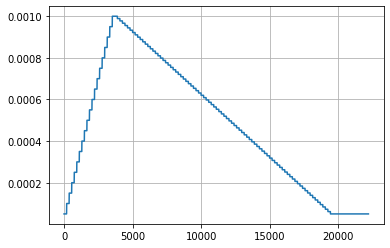

In [14]:
learning_rate = MySchedule(init_lr=5e-5,peak_lr=1e-3,bottom_lr=5e-5,up_epochs=20,decay_epochs=85,epoch_steps=185)
epochs = 120
steps_list = tf.cast(tf.range(epochs*185), tf.float32); lr_list = learning_rate(steps_list)
plt.plot(lr_list); plt.grid()

In [15]:
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model = Transformer()
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), metrics=[keras.metrics.SparseCategoricalAccuracy()],
              optimizer=optimizer)

In [16]:
model.fit(train_ds, epochs=epochs)

Epoch 1/120
185/185 [==============================] - 55s 260ms/step - 张泰龙_留白: 0.8880 - 张泰龙_cost: 1.4870 - MyAcc: 0.2122
Epoch 2/120
185/185 [==============================] - 48s 258ms/step - 张泰龙_留白: 0.8880 - 张泰龙_cost: 1.2180 - MyAcc: 0.2762
Epoch 3/120
185/185 [==============================] - 48s 257ms/step - 张泰龙_留白: 0.8880 - 张泰龙_cost: 1.1934 - MyAcc: 0.2857
Epoch 4/120
185/185 [==============================] - 48s 258ms/step - 张泰龙_留白: 0.8880 - 张泰龙_cost: 1.1724 - MyAcc: 0.2957
Epoch 5/120
185/185 [==============================] - 48s 258ms/step - 张泰龙_留白: 0.8880 - 张泰龙_cost: 1.1347 - MyAcc: 0.3193
Epoch 6/120
185/185 [==============================] - 48s 259ms/step - 张泰龙_留白: 0.8880 - 张泰龙_cost: 1.0785 - MyAcc: 0.3523
Epoch 7/120
185/185 [==============================] - 49s 261ms/step - 张泰龙_留白: 0.8880 - 张泰龙_cost: 1.0410 - MyAcc: 0.3744
Epoch 8/120
185/185 [==============================] - 48s 257ms/step - 张泰龙_留白: 0.8880 - 张泰龙_cost: 1.0080 - MyAcc: 0.3927
Epoch 9/120
185/185 [===

In [17]:
t_vocab = (
            ["-", "#", "<", ">"]
            + [chr(i + 96) for i in range(1, 27)]
            + [" ", ".", ",", "?"]
        )

In [18]:
b_th = 0
for t_in, t_out in val_ds.take(30):
    b_th += 1
    t_enc_in, t_ = t_in
    t_pre_ids = model.generate(t_enc_in)
    print(f"这是第{b_th}批次",'#'*80)
    t_batch = tf.shape(t_out)[0]
    for i in range( t_batch.numpy() ):
        print('先打印真实值:')
        t_true = "".join([t_vocab[_] for _ in t_out[i]])
        t_true = t_true.replace("-","")
        print(t_true)
        print('再打印预测值:')
        t_pred = ""
        for t_id in t_pre_ids[i]:
            if t_id == 3:
                break
            t_pred += t_vocab[t_id]
        print(t_pred)

[[31 3 31 ... 3 31 3]
 [3 3 7 ... 3 31 3]]
这是第1批次 ################################################################################
先打印真实值:
many factors were undoubtedly involved in oswald#s motivation for the assassination, and the commission does not believe>
再打印预测值:
<many factors were undoubtedly involved motivation, and tho assassination doubtedly eve
先打印真实值:
that it can ascribe to him any one motive or group of motives.>
再打印预测值:
<that it cannanws, scribed to him otiwered any one motive motives.
先打印真实值:
it is apparent, however, that oswald was moved by an overriding hostility to his environment.>
再打印预测值:
<it is apparent, however that oswald was moved by in hostillity to his and by an over that over that.
先打印真实值:
he does not appear to have been able to establish meaningful relationships with other people. he was perpetually discontented with the world around him.>
再打印预测值:
<he dr. petsuabliships with of other petsurly disconted with other peture peatuallly diships with of other petcua

这是第9批次 ################################################################################
先打印真实值:
which recommends additional personnel and facilities to enable the secret service to expand its protection capabilities.>
再打印预测值:
<which recommends additional personal and its protection king a dititional personal and its prose to expengeds,
先打印真实值:
the secretary of the treasury submitted this planning document on august thirtyone, nineteen sixtyfour,>
再打印预测值:
<the secretary submen nineteen dockument nineteen sixty four, nineteen sixty four,
先打印真实值:
to the bureau of the budget for review and approval.>
再打印预测值:
<to the budge it for riview and proval.
先打印真实值:
this planning document has been made a part of the commission#s published record# the underlying staff and consultants# reports reviewed by the commission have not,>
再打印预测值:
<this plants reports, reports, recommission have not, the underlined commission have not, and consultents recored #record the commission have not
[[31 3 3 ... 3 7 31]

<in recent and extensive, presidential jurney ears presidential jurney earsive,
[[31 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]
这是第17批次 ################################################################################
先打印真实值:
partly because of the greater speed and comfort of travel and partly because of the greater demands made on the president.>
再打印预测值:
<partly because of the greater demands made on the president. partly because of the greater speed and partly because of travel travel travel travel.
先打印真实值:
it is now possible for presidents to travel the length and breadth of a land far larger than the united states>
再打印预测值:
<it is now president#s to trable land far larger than the united states to trable lankth of a length lank nith the #length length units
先打印真实值:
in seventeen eightynine in less time than it took george washington to travel from new york to mount vernon>
再打印预测值:
<insever, jor to travel from new york jork jork jork jork jork ushington, took jork jork ine in lesss time than
先

<the degree of security of security of security of four the united states
[[3 3 3 ... 31 3 3]
 [3 3 3 ... 3 3 3]]
这是第25批次 ################################################################################
先打印真实值:
is dependent to a considerable extent upon the degree of contact with the general public desired by the president.>
再打印预测值:
<is dependent tact with the jeneral extent act with the jeneral public serable exirable extent and in gereal public stent.
先打印真实值:
absolute security is neither practical nor possible. an approach to complete security would require the president>
再打印预测值:
<and approached the complete security, would nor possible, is neither president he president he president,
先打印真实值:
to operate in a sort of vacuum, isolated from the general public and behind impregnable barriers.>
再打印预测值:
<to appray i sourt of vaccumbariors, i so operate in asso uperior operate in a so opertoperates.
先打印真实值:
his travel would be in secret# his public appearances would be behind bulletproof gl